# Experimentation

Let's load the data and configs from the previous notebook first.

In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext memory_profiler

import pickle
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import requests
from IPython.display import display

import azs_helpers.l2r_helper as azs
from azs_helpers.azure_search_client import azure_search_client as azs_client 

interim_data_dir = Path.cwd() / 'data' / 'interim'
df = pd.read_csv(interim_data_dir / 'normalized_features.csv')

display(df.head(5))

,Unnamed: 0,grade,@search.score,normalized_pageview,tableCount,sectionCount,@search.features.body_en_us.uniqueTokenMatches,@search.features.body_en_us.similarityScore,@search.features.body_en_us.termFrequency,@search.features.description_en_us.uniqueTokenMatches,...,@search.features.title_en_us.termFrequency,@search.features.searchTerms.uniqueTokenMatches,@search.features.searchTerms.similarityScore,@search.features.searchTerms.termFrequency,@search.features.urlPath.uniqueTokenMatches,@search.features.urlPath.similarityScore,@search.features.urlPath.termFrequency,query_id,title_length_in_words,title_length_in_chars
0,3808,10,0.304274,1.000000,0.333333,1.000000,0.0,0.304274,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.285714,0.488889
1,3809,8,0.591270,0.000000,0.000000,0.000000,0.0,0.591270,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.844444
2,3810,6,0.000000,0.352170,0.333333,0.153846,0.0,0.000000,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.571429,0.755556
3,3811,4,1.000000,0.333333,0.000000,0.153846,0.0,1.000000,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.571429,0.577778
4,3812,3,0.248711,0.274194,0.000000,0.153846,0.0,0.248711,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,1.000000


## Split dataset into features and judgments

The machine learning libraries we're using expect us to separate our training data into features $X$ and judgment values $y$. Let's do that real quick: 


In [2]:
X, y = df.drop(columns=['grade', 'query_id'], axis=1), df.grade

### Hold out a portion of the data for testing.

We need to hold out part of the data to validate that our model works.

For this tutorial, we will hold out **10%** of the data using `scikit-learn.model_selection.GroupShuffleSplit`. This means that the model will use **90%** of the queries for training & validation, while **10%** of the queries (that the model has never seen before) will be used to evaluate the final model's performance.

#### Query labels for documents

Our data preparation and model training process must be aware of query-document relationships in our dataset for accurate training results, so we'll need to pass in the query labels (`query_ids`) as well. The reason this is important is because the loss function used for optimization depends on the NDCG. As discussed above, the NDCG is a metric which indicates how close is an ordered list to its ideal order. To achieve this, the model needs to be aware of how to create those lists out of the training set, which can be achieved by grouping the data using the query_id.

Read the following references for more information:

- [Scikit-Learn: Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Scikit-Learn: GroupShuffleSplit](https://scikit-learn.org/stable/modules/cross_validation.html#group-shuffle-split)

In [3]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

# Hold out 10% of our queries in the test set.
random_seed = 42 # we are using a static random seed so we can easily reproduce results. The actual number has no meaning.
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=random_seed)

# Query labels for each document in our dataset.
query_ids = df['query_id'].to_numpy()

train_index, test_index = next(gss.split(X, y, groups=query_ids))
print(f"Number of samples in train: {len(train_index)}")
print(f"Number of samples in test: {len(test_index)}")

# Split our features, judgment values, and query labels into train & test sets.
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
query_ids_train, query_ids_test = query_ids[train_index], query_ids[test_index]

Number of samples in train: 8052
Number of samples in test: 916


# Model Setup

Now that we've completed our feature engineering steps, we can move on to running our experiment. We'll be using the open-source [XGBoost library](https://xgboost.readthedocs.io/en/latest/index.html), which includes a few implementations of [**Pairwise**](https://en.wikipedia.org/wiki/Learning_to_rank#Pairwise_approach) and [**Listwise**](https://en.wikipedia.org/wiki/Learning_to_rank#Listwise_approach) ranking algorithms.

By setting `'objective': 'rank:ndcg'` in the model constructor, we've chosen to use the [LambdaMART](https://www.microsoft.com/en-us/research/publication/from-ranknet-to-lambdarank-to-lambdamart-an-overview/) algorithm to maximize **listwise** [NDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain).

Another objective function that can be used for this problem is `rank:pairwise`, which will perform **pairwise** training instead of listwise training.

### Further Reading:
- [Learning to Rank: From Pairwise Approach to Listwise Approach](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-2007-40.pdf)
- XGBoost Documentation links:
    - [XGBRanker Class](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRanker)
    - [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [4]:
import xgboost as xgb

params = {'objective': 'rank:ndcg', 'learning_rate': 0.1,
          'gamma': 1.0, 'min_child_weight': 0.1,
          'max_depth': 8, 'n_estimators': 500}

ranker = xgb.XGBRanker(**params)
ranker

XGBRanker(base_score=None, booster=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, gamma=1.0, gpu_id=None,
          importance_type='gain', interaction_constraints=None,
          learning_rate=0.1, max_delta_step=None, max_depth=8,
          min_child_weight=0.1, missing=nan, monotone_constraints=None,
          n_estimators=500, n_jobs=None, num_parallel_tree=None,
          objective='rank:ndcg', random_state=None, reg_alpha=None,
          reg_lambda=None, scale_pos_weight=None, subsample=None,
          tree_method=None, validate_parameters=False, verbosity=None)

### Train with K-Fold Cross Validation

K-Fold cross validation is a robust way to avoid overfitting during model training. Let's train with K-fold cross validation with `K=9`. We'll be using `scikit-learn`'s [GroupKFold class](https://scikit-learn.org/stable/modules/cross_validation.html#group-k-fold) to split our training data into 9 approximately even-sized portions. `GroupKFold` ensures that all documents for a particular query remain within the same fold. Before we can get started, we'll need to augment our query labels for training.
- If you're running this on Binder, please set `n_splits = 2` in the code.

#### Computing Document counts per Query

During the training phase, we need to transform our query labels to be compatible with XGBoost. The `GroupKFold` cross-validation tool provided by `scikit-learn` expects a group (or query) label for every document in the dataset. We've already provided this in the form of `query_ids`.

Let's take a look at the example below. Given a simple dataset of 3 queries:

- Query 1: [doc1, doc2, doc3]
- Query 2: [doc4]
- Query 3: [doc5, doc6]

**`scikit-learn` expects the following format**:

```python
# query_ids = [query1, query1, query1, query2, query3, query3]
query_ids = [1, 1, 1, 2, 3, 3]
```

**`xgboost` expects the following format**:

```python
query_doc_counts = [3, 1, 2]
```
    
`xgboost` expects document counts for each query (as opposed to a query label for every document), sorted by query. We can take our scikit-learn compatible query labels and aggregate them using numpy, as follows:

```python
labels, query_doc_counts = np.unique(query_ids, return_counts=True)
```

or, alternatively:
```python
query_doc_counts = np.unique(query_group_labels, return_counts=True)[1]
```

For reference, please refer to the [XGBoost Docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRanker)

### Calculating our Results
Calling `ranker.predict(X_test)` here will allow us to get all of the results. `xgb_scores` is a flat list of scores for queries in the test set. The raw scores are grouped by query and processed within a helper function to compute the precited rankings. Feel free to read the docstring of `azs_helpers.l2r_helper.scores_to_rankings` for more information.

In [5]:
%%time
from sklearn.model_selection import GroupKFold

def calculate_ndcg_for_experiment(ranker, X, y, query_ids):
    # **NOTE**
    # If you are running this on Binder, please change n_splits to 2 for a faster run! Or skip this part entirely.
    n_splits = 9
    group_kfold = GroupKFold(n_splits)

    ndcg_results = []

    for train_idx, validation_idx in group_kfold.split(X, y, groups=query_ids):
        X_train_fold, X_validation_fold = X.iloc[train_idx], X.iloc[validation_idx]
        y_train_fold, y_validation_fold = y.iloc[train_idx], y.iloc[validation_idx]
        
        # XGBoost expects query counts instead of query labels.
        # https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array
        train_groups_xgb = np.unique(query_ids[train_idx], return_counts=True)[1]
        validation_groups_xgb = np.unique(query_ids[validation_idx], return_counts=True)[1]
        
        ranker.fit(X_train_fold, y_train_fold, train_groups_xgb,
                   eval_set=[(X_validation_fold, y_validation_fold)], eval_group=[validation_groups_xgb],
                   eval_metric='ndcg',
                   verbose=False)
        xgb_scores = ranker.predict(X_validation_fold)
        model_judgments, azs_judgments, baseline = azs.scores_to_rankings(xgb_scores, validation_groups_xgb, X_validation_fold, y_validation_fold)
        ndcg_results_for_fold = azs.evaluate_ndcg(k_start=1, k_end=10, azs=azs_judgments, predicted=model_judgments)
        ndcg_results.append(ndcg_results_for_fold)

    return ndcg_results

# %memit ndcg_results = calculate_ndcg_for_experiment(ranker, X_train, y_train, query_ids_train)
ndcg_results = calculate_ndcg_for_experiment(ranker, X_train, y_train, query_ids_train)

Wall time: 1min 3s


### Visualize Cross-Validation Results

Now that we've trained our model multiple times, we can visualize the training results.

Datapoints represent the mean across all training runs, while vertical bars are the standard deviation.

----------- NDCG mean across all 9 folds --------------


,azs,predicted
1,0.689050,0.803878
2,0.705974,0.793539
3,0.718176,0.793155
4,0.738818,0.797621
5,0.758370,0.809069
6,0.781562,0.827717
7,0.806757,0.848309
8,0.833665,0.869990
9,0.861198,0.894563
10,0.882663,0.913685


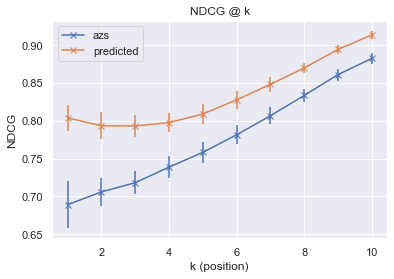

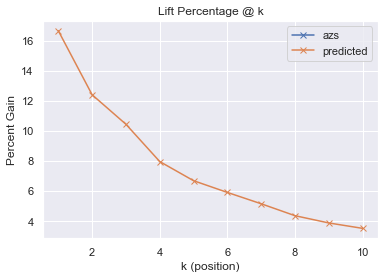

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

azs.show_ndcg_results(ndcg_results, 1, 10)

### Putting it all together

Now that we're confident that our model performs better than Azure Search's built-in retrieval algorithm, let's run it against the test set! This time around, we'll be using all of the training data available to us.

,azs,predicted
1,0.684702,0.795481
2,0.702579,0.802040
3,0.729504,0.795863
4,0.739498,0.798097
5,0.755819,0.808994
6,0.774718,0.828651
7,0.804055,0.851832
8,0.828377,0.872967
9,0.862031,0.896050
10,0.882415,0.914760


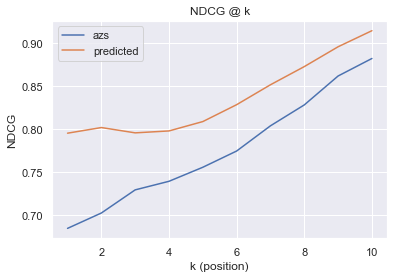

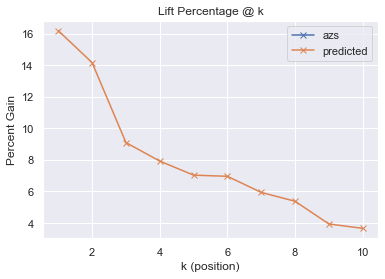

In [7]:
train_groups_xgb = np.unique(query_ids_train, return_counts=True)[1]
test_groups_xgb = np.unique(query_ids_test, return_counts=True)[1]

ranker.fit(X_train, y_train, train_groups_xgb,
           eval_metric='ndcg',
           verbose=False)

xgb_scores = ranker.predict(X_test)
model_judgments, azs_judgments, baseline = azs.scores_to_rankings(xgb_scores, test_groups_xgb, X_test, y_test)

test_ndcg_results = azs.evaluate_ndcg(k_start=1, k_end=10, plot=True, show_lift=True, azs=azs_judgments, predicted=model_judgments)

### Feature Importances
We can view which features ended up being the most important in our trained model:

In [8]:
feature_importances = dict(zip(X_train.columns, ranker.feature_importances_))
feature_importances_sorted = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}
feature_importances_sorted

{'@search.features.searchTerms.termFrequency': 0.26863083,
 '@search.score': 0.054235756,
 '@search.features.searchTerms.similarityScore': 0.041803934,
 '@search.features.description_en_us.uniqueTokenMatches': 0.034239154,
 'normalized_pageview': 0.03409484,
 '@search.features.title_en_us.similarityScore': 0.032406945,
 '@search.features.urlPath.similarityScore': 0.0314617,
 '@search.features.description_en_us.termFrequency': 0.03087834,
 'Unnamed: 0': 0.03056809,
 '@search.features.title_en_us.termFrequency': 0.029988198,
 'title_length_in_chars': 0.029768622,
 'tableCount': 0.02962415,
 'sectionCount': 0.029478395,
 '@search.features.urlPath.termFrequency': 0.029295016,
 'title_length_in_words': 0.029177012,
 '@search.features.body_en_us.similarityScore': 0.028783064,
 '@search.features.description_en_us.similarityScore': 0.027728822,
 '@search.features.keyPhrases_en_us.similarityScore': 0.02745287,
 '@search.features.body_en_us.termFrequency': 0.027402781,
 '@search.features.title_e

### How to re-rank a search request's results using our trained model
When re-ranking an Azure Search query, we need to go through the same process to transform the results into features as we did for our training data. 

This means

1. Get features from Azure Search
2. Compute any additional features that was used int raining
3. Apply the same level of normalization 

Once we get the features in the expected format, we can feed them into the trained model to infer a new order, which will be used to re-rank our results.

In [9]:
def rerank_search_query(service, query, model, expected_features):
    expected_features_format = pd.DataFrame(columns = expected_features, dtype='float64')
    
    json_search_results = azs.get_search_results_from_service(service, query, [])
    search_results = pd.json_normalize(json_search_results).fillna(0)
    search_results["query"] = query

    search_features = azs.customize_features(search_results.drop(columns=['url_en_us'], axis=1))
    normalized_search_features = azs.normalize_features(expected_features_format.append(search_features))
    
    prediction_score = model.predict(normalized_search_features.drop(columns=['query_id'], axis=1, errors='ignore'))
    search_results['prediction'] = prediction_score

    new_df = pd.DataFrame()
    new_df['Base Azure Search order'] = search_results.apply(lambda row: "{0}\n{1}".format(row['title_en_us'], row['url_en_us']), axis=1) 
    new_df['Trained model order'] = search_results.sort_values('prediction', ascending=False).apply(lambda row: "{0}\n{1}".format(row['title_en_us'], row['url_en_us']), axis=1).tolist() #['title_en_us'].tolist()

    return new_df
service_metadata_config_path = Path.cwd() / 'config' / 'config.json'
azs_service = azs_client.from_json(service_metadata_config_path)
azs.pretty_print(rerank_search_query(azs_service, 'Windows Server 2019', ranker, X.columns))

C:\Users\Zephyr\Anaconda3\envs\azs-l2r\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'azszorl.eastus.cloudapp.azure.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Zephyr\Anaconda3\envs\azs-l2r\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'azszorl.eastus.cloudapp.azure.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Zephyr\Anaconda3\envs\azs-l2r\lib\site-packages\sklearn\preprocessing\_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Zephyr\Anaconda3\envs\azs-l2r\lib\site-packages\sklearn\preprocessing\_data.py:376: RuntimeWarning: All-NaN slic

,Base Azure Search order,Trained model order
0,Upgrade Windows Server 2016 to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/upgrade/upgrade-2016-to-2019,Windows Server 2019 System Requirementshttps://docs.microsoft.com/en-us/windows-server/get-started-19/sys-reqs-19
1,Upgrade Windows Server 2012 R2 to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/upgrade/upgrade-2012r2-to-2019,Comparison of Standard and Datacenter editions of Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/editions-comparison-19
2,Overview of Windows Server IoT 2019 - Windows IoThttps://docs.microsoft.com/en-us/windows/iot-core/windows-server,"Install, upgrade, or migrate to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/install-upgrade-migrate-19"
3,Upgrade to SharePoint Server 2019https://docs.microsoft.com/en-us/sharepoint/upgrade-and-update/upgrade-to-sharepoint-server-2019,Upgrade Windows Server 2016 to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/upgrade/upgrade-2016-to-2019
4,Windows Server 2019 System Requirementshttps://docs.microsoft.com/en-us/windows-server/get-started-19/sys-reqs-19,What's new in Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/whats-new-19
5,Windows Defender Antivirus on Windows Server 2016 and 2019 - Windows securityhttps://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-antivirus/windows-defender-antivirus-on-windows-server-2016,Windows Server Documentation - Microsoft Docshttps://docs.microsoft.com/en-us/windows-server/
6,What's new in Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/whats-new-19,Upgrade Windows Server 2012 R2 to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/upgrade/upgrade-2012r2-to-2019
7,What's new in Windows 10 Enterprise 2019 LTSC - What's new in Windowshttps://docs.microsoft.com/en-us/windows/whats-new/ltsc/whats-new-windows-10-2019,Overview of Windows Server IoT 2019 - Windows IoThttps://docs.microsoft.com/en-us/windows/iot-core/windows-server
8,Visual Studio 2019 System Requirementshttps://docs.microsoft.com/en-us/visualstudio/releases/2019/system-requirements,Visual Studio 2019 version 16.4 Release Noteshttps://docs.microsoft.com/en-us/visualstudio/releases/2019/release-notes
9,"Install, upgrade, or migrate to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/install-upgrade-migrate-19",Visual Studio 2019 System Requirementshttps://docs.microsoft.com/en-us/visualstudio/releases/2019/system-requirements
